In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2


In [2]:
# model = coralme.io.json.load_json_me_model("../ACCELERATE/models/pputida-2024_05_20/KT2440-UPF36-DLKcat-Transport10.json")

### Load predictions

In [3]:
fluxes = pandas.read_csv("./datasets/predictions/KT2440-UPF36-M9-cost.csv",index_col=0)

In [4]:
pred = fluxes[fluxes.index.str.contains("SK_protein")]["reduced_costs"]
pred = pred[pred<0].abs()
pred.name = "predicted"
pred.index = [r.split("SK_protein_")[-1] for r in pred.index]

### Load omics data

In [5]:
rna = pandas.read_csv("./data-jul-2024/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [6]:
ribo = pandas.read_csv("./data-jul-2024/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [7]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
te_samples = [i + "_te" for i in samples]
all_samples = samples+rna_samples+te_samples+["predicted"]
colors = ["#2b83ba","#66bd63","#fdae61"]

### Load Annotation

In [8]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0)

### Combine results

In [9]:
NormalizedRibo = ribo.div(ribo.sum())*1e6
NormalizedRNA = rna.div(rna.sum())*1e6
NormalizedTE = NormalizedRibo.div(NormalizedRNA,axis=0)
Results = NormalizedRibo.join(NormalizedRNA,rsuffix="_rna").join(NormalizedTE,rsuffix="_te").join(pred)
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem
PP_0001,115.346129,101.379836,117.392753,0.428368,1.142857,1.386889,269.268957,88.707377,84.644676,NaN,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN
PP_0010,649.987487,654.840617,574.275588,0.870122,2.032432,1.871958,747.007359,322.195592,306.777985,NaN,PP_RS00050,dnaA,chromosomal replication initiator protein DnaA,CDS,1521.0,NaN
PP_0097,20.691063,14.890996,21.743415,0.053546,0.358301,0.321102,386.416850,41.560009,67.714909,NaN,PP_RS00495,NaN,YheV family putative zinc ribbon protein,CDS,282.0,NaN
PP_0947,32.817598,33.777137,39.853891,0.087012,0.129730,0.136639,377.160906,260.365490,291.672262,NaN,PP_RS04975,NaN,ZIP family metal transporter,CDS,894.0,NaN
PP_0948,14.117067,14.164606,29.334633,0.046853,0.098842,0.109311,301.307316,143.306005,268.358322,NaN,PP_RS04980,NaN,HPr family phosphocarrier protein,CDS,273.0,NaN


In [10]:
ResultsAnnotated.dropna(subset="predicted").sort_values("predicted")

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem
PP_1664,195.150774,181.912278,233.484155,0.100399,0.339768,0.382590,1943.758280,535.401035,610.272478,3.298316e-28,PP_RS08570,purN,phosphoribosylglycinamide formyltransferase,CDS,654.0,Metabolic:S_Purine_Metabolism
PP_4188,1468.044028,1509.559559,1365.876882,1.827256,11.057912,16.014125,803.414509,136.513973,85.292009,1.626022e-03,PP_RS21745,odhB,2-oxoglutarate dehydrogenase complex dihydrolipoyllysine-residue succinyltransferase,CDS,1224.0,Metabolic:S_TCA_Cycle
PP_2334,62.492249,53.341242,75.207274,0.281116,0.253282,0.355262,222.300327,210.600378,211.695148,6.073848e-03,PP_RS12180,prpB,methylisocitrate lyase,CDS,891.0,Metabolic:S_Alternate_Carbon__Propanoate_Metabolism
PP_4300,9.009779,8.183994,8.838346,0.174024,0.067954,0.027328,51.773085,120.434946,323.418903,1.159864e-02,PP_RS22330,NaN,glycerate kinase,CDS,1275.0,Metabolic:S_Glyoxylate_and_dicarboxylate_metabolism
PP_1771,910.197250,873.484018,612.340120,0.401595,2.131274,2.480003,2266.457111,409.841329,246.911029,2.429539e-02,PP_RS09100,cmk,(d)CMP kinase,CDS,687.0,Metabolic:S_Pyrimidine_Metabolism
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_2638,11.707475,9.225153,12.145948,0.240957,0.166795,0.136639,48.587435,55.308225,88.890594,1.780266e+01,PP_RS13745,bcsC,cellulose synthase complex outer membrane protein BcsC,CDS,3519.0,Metabolic:S_Cell_Envelope_Biosynthesis__Cellulose_Metabolism
PP_1777,383.256111,425.591922,284.941763,0.883508,1.760617,2.261380,433.788859,241.728802,126.003472,1.799581e+01,PP_RS09130,NaN,phosphomannomutase/phosphoglucomutase,CDS,1362.0,Metabolic:S_Alternate_Carbon__Ribose_Metabolism
PP_4220,36.589133,35.399408,37.088519,0.589006,0.345946,0.423582,62.120177,102.326437,87.559283,2.045938e+01,PP_RS21910,NaN,non-ribosomal peptide synthetase,CDS,7887.0,Metabolic:S_Iron_uptake_and_metabolism
PP_1333,226.894532,206.294770,199.269454,0.863429,2.538996,2.179397,262.783175,81.250544,91.433311,3.023406e+01,PP_RS06895,murF,UDP-N-acetylmuramoyl-tripeptide--D-alanyl-D- alanine ligase,CDS,1368.0,Metabolic:S_Cell_Envelope_Biosynthesis__Peptidoglycan_Biosynthesis


###  Group by subsystem

In [11]:
FluxesAnnotated = pandas.read_csv("./datasets/performance/KT2440-UPF36-M9-ResultsAnnotated.csv")
FluxesGrouped = FluxesAnnotated[rna_samples+samples+["predicted","subsystem"]].groupby("subsystem").sum()
FluxesGrouped[te_samples] = FluxesGrouped[samples].div(FluxesGrouped[rna_samples].rename(columns={i:j for i,j in zip(rna_samples,samples)}),axis=1)

In [12]:
ResultsGrouped = ResultsAnnotated[rna_samples+samples+["predicted","subsystem"]].groupby("subsystem").sum()
ResultsGrouped[te_samples] = ResultsGrouped[samples].div(ResultsGrouped[rna_samples].rename(columns={i:j for i,j in zip(rna_samples,samples)}),axis=1)

In [13]:
ResultsGrouped["predicted"] = ResultsGrouped["predicted"] + 1
FluxesGrouped["predicted"] = FluxesGrouped["predicted"] + 1

<Axes: xlabel='predicted', ylabel='fluxes'>

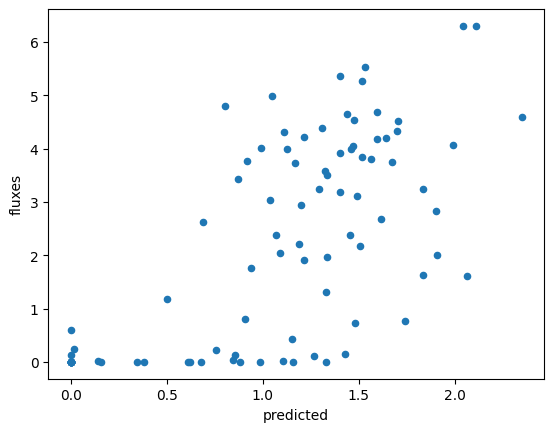

In [14]:
df = pandas.concat([ResultsGrouped["predicted"],FluxesGrouped.rename(columns={"predicted":"fluxes"})["fluxes"]],axis=1)
numpy.log10(df).plot.scatter(x="predicted",y="fluxes")

### Ribo

In [15]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
from scipy.stats import pearsonr

In [16]:
import cobra
cobra.__version__

'0.26.3'

PearsonRResult(statistic=0.7457922618629295, pvalue=1.0098269518574533e-49)


Text(0.5, 1.0, 'Ribo-Seq vs. ME-model')

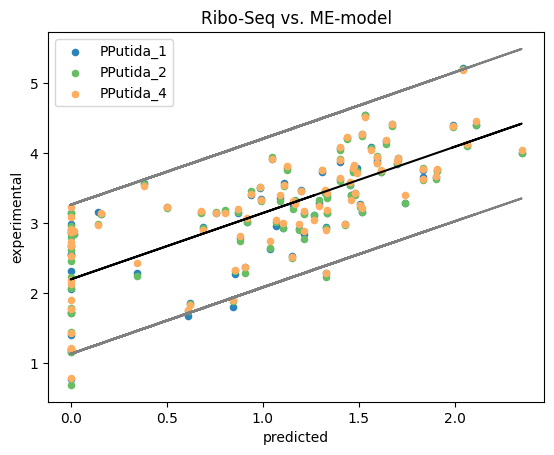

In [17]:
slist = samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
# colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))


# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("Ribo-Seq vs. ME-model")



In [18]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,3.120379,2.339705,4.462584,3.401145,1.269942
Metabolic: No subsystem,PPutida_2,3.111053,2.339705,4.462584,3.401145,1.269942
Metabolic: No subsystem,PPutida_4,3.052351,2.339705,4.462584,3.401145,1.269942
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,0.766461,1.130796,3.263743,2.197270,0.000000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,0.687245,1.130796,3.263743,2.197270,0.000000


### RNA

PearsonRResult(statistic=0.7272087872571456, pvalue=3.44533353794456e-46)


Text(0.5, 1.0, 'RNA-Seq vs. ME-model')

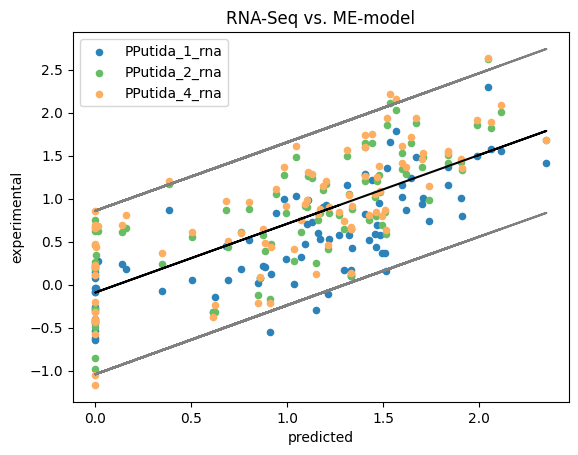

In [19]:
slist = rna_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("RNA-Seq vs. ME-model")



In [20]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,0.573825,-0.021295,1.870579,0.924642,1.269942
Metabolic: No subsystem,PPutida_2,0.804500,-0.021295,1.870579,0.924642,1.269942
Metabolic: No subsystem,PPutida_4,0.848225,-0.021295,1.870579,0.924642,1.269942
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,-0.540895,-1.041077,0.859770,-0.090653,0.000000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,-0.978731,-1.041077,0.859770,-0.090653,0.000000


## TE

PearsonRResult(statistic=0.30165383313631555, pvalue=3.7723920796833917e-07)


Text(0.5, 1.0, 'TE vs. ME-model')

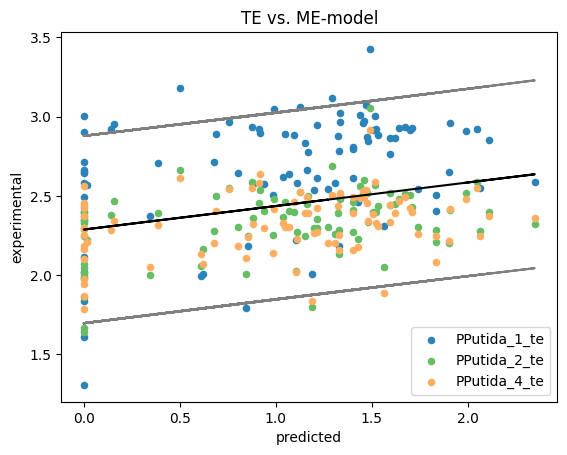

In [21]:
slist = te_samples
tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],label=s)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.title("TE vs. ME-model")



In [22]:
tmp.columns = samples+["predicted"]
Stacked = tmp[samples].stack().reset_index().rename(columns={0:"value"}).set_index("subsystem")
Stacked["ci_low"] = predict_ci_low
Stacked["ci_upp"] = predict_ci_upp
Stacked["fit"] = fittedvalues
Stacked["predicted"] = X
Stacked.head()

,level_1,value,ci_low,ci_upp,fit,predicted
subsystem,,,,,,
Metabolic: No subsystem,PPutida_1,2.546555,1.888189,3.064816,2.476502,1.269942
Metabolic: No subsystem,PPutida_2,2.306553,1.888189,3.064816,2.476502,1.269942
Metabolic: No subsystem,PPutida_4,2.204126,1.888189,3.064816,2.476502,1.269942
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_1,1.307355,1.696820,2.879027,2.287923,0.000000
Metabolic:Aliphatic open-chain ketones metabolism,PPutida_2,1.665976,1.696820,2.879027,2.287923,0.000000


# By sample

### Ribo

PearsonRResult(statistic=0.743853922547454, pvalue=2.9899738871742285e-17)
PearsonRResult(statistic=0.7468732004525722, pvalue=1.89780037499821e-17)
PearsonRResult(statistic=0.7469571933967544, pvalue=1.873781155632577e-17)


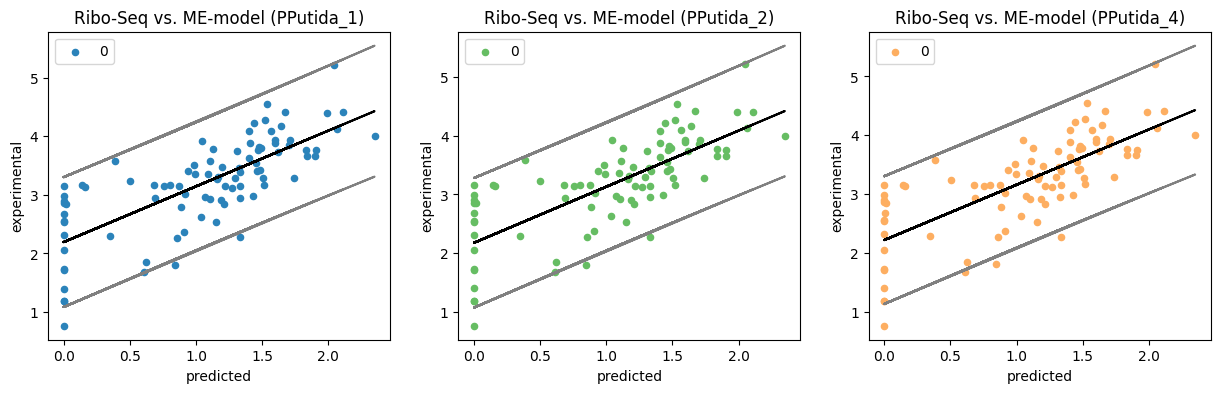

In [23]:
slist = samples
s = 0
fig,ax = plt.subplots(1,3,figsize=(15,4))
for idx,sample in enumerate(slist):
    a = ax[idx]
    tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
    # colors = ["brown","blue","green"]
    X = tmp["predicted"].values
    y = tmp[sample].values
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    tmp.plot.scatter("predicted",s,ax=a,color=colors[idx],label=s)
    a.plot(X,est2.predict(),color="black")
    a.set_ylabel("experimental")
    print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))
    
    # Confidence interval
    st, data, ss2 = summary_table(est2, alpha=0.05)
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    a.plot(X, predict_ci_low, color="gray")
    a.plot(X, predict_ci_upp, color="gray")
    a.set_title("Ribo-Seq vs. ME-model ({})".format(sample))

### TE

PearsonRResult(statistic=0.3879221552237526, pvalue=0.00014510933452038327)
PearsonRResult(statistic=0.3968301048898474, pvalue=9.845933109189763e-05)
PearsonRResult(statistic=0.2860241875090969, pvalue=0.005987813820028876)


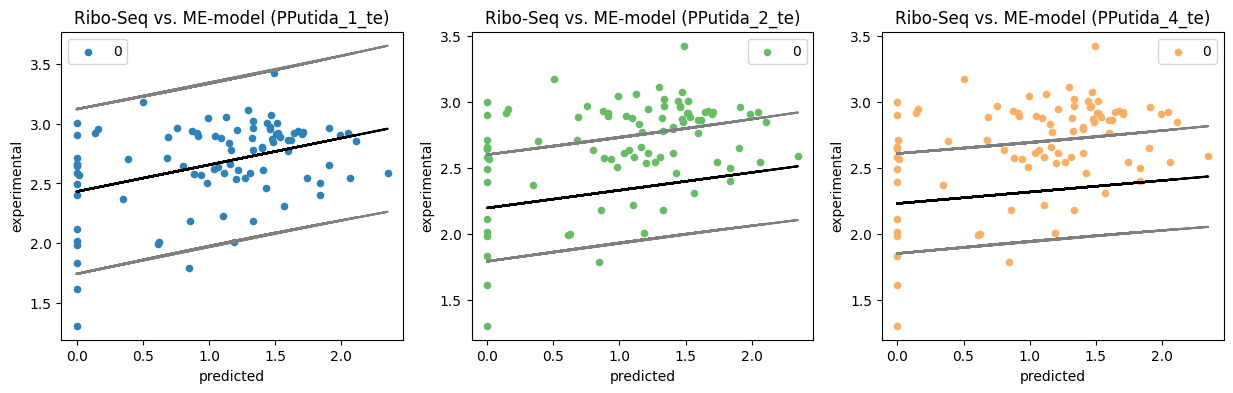

In [24]:
slist = te_samples
s = 0
fig,ax = plt.subplots(1,3,figsize=(15,4))
for idx,sample in enumerate(slist):
    a = ax[idx]
    tmp = numpy.log10(ResultsGrouped[slist+["predicted"]]).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
    # colors = ["brown","blue","green"]
    X = tmp["predicted"].values
    y = tmp[sample].values
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    tmp.plot.scatter("predicted",s,ax=a,color=colors[idx],label=s)
    a.plot(X,est2.predict(),color="black")
    a.set_ylabel("experimental")
    print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))
    
    # Confidence interval
    st, data, ss2 = summary_table(est2, alpha=0.05)
    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    a.plot(X, predict_ci_low, color="gray")
    a.plot(X, predict_ci_upp, color="gray")
    a.set_title("Ribo-Seq vs. ME-model ({})".format(sample))

### Subsystems

In [25]:
def calculate_score(df,cutoff=100):
    experimental = df[df>cutoff].any(axis=1)
    experimental.name = "experimental"
    predicted = df["predicted"]>1e-16
    results = pandas.concat([experimental,predicted],axis=1)

    TP = results[(results["experimental"] == True) & (results["predicted"] == True)].shape[0]
    TN = results[(results["experimental"] == False) & (results["predicted"] == False)].shape[0]
    FP = results[(results["experimental"] == False) & (results["predicted"] == True)].shape[0]
    FN = results[(results["experimental"] == True) & (results["predicted"] == False)].shape[0]

    T = TP + FN
    N = TN + FP
    
    dct =  {"TP":TP,"TN":TN,"FP":FP,"FN":FN}
    dct["TPR"] = TP/T if T else numpy.nan
    dct["TNR"] = TN/N if N else numpy.nan
    dct["FDR"] = FP/(TP+FP)
    dct["FOR"] = FN/(TN+FN)
    dct["BA"] = (dct["TPR"] + dct["TNR"])/2
    dct["MCC"] = numpy.sqrt(dct["TPR"]*dct["TNR"]*(1-dct["FDR"])*(1-dct["FOR"]))
    return dct,results

<Axes: >

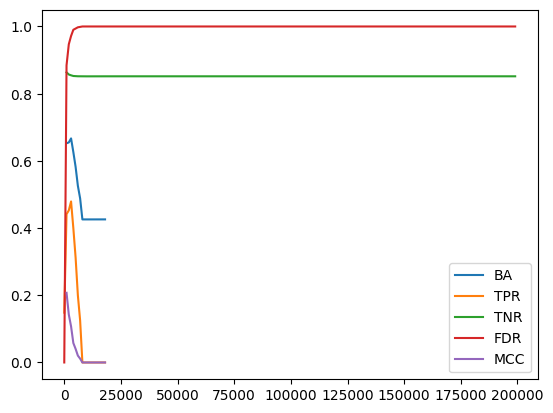

In [26]:
Res = {}
for i in range(0,200000,1000):
    dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]],cutoff=i)
    Res[i] = dct
pandas.DataFrame.from_dict(Res).T[["BA","TPR","TNR","FDR","MCC"]].plot()

<Axes: >

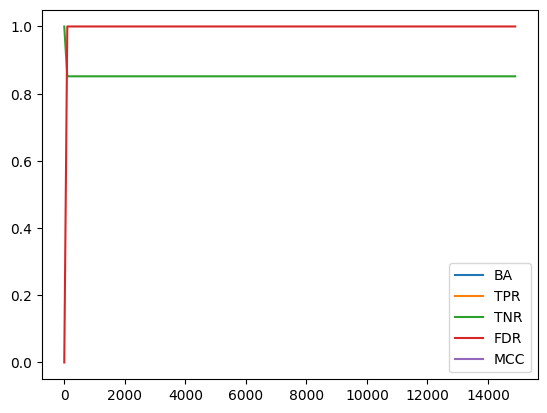

In [27]:
Res = {}
for i in range(0,15000,100):
    dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]],cutoff=i)
    Res[i] = dct
pandas.DataFrame.from_dict(Res).T[["BA","TPR","TNR","FDR","MCC"]].plot()

In [28]:
pandas.DataFrame.from_dict(Res)

,0,100,200,300,400,500,600,700,800,900,...,14000,14100,14200,14300,14400,14500,14600,14700,14800,14900
TP,812.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TN,8.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,...,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000
FP,0.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,...,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000
FN,4656.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TPR,0.148500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TNR,1.000000,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717,...,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717,0.851717
FDR,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FOR,0.998285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BA,0.574250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MCC,0.015960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]],cutoff=1000)
dct

{'TP': 94,
 'TN': 4545,
 'FP': 718,
 'FN': 119,
 'TPR': 0.4413145539906103,
 'TNR': 0.8635759072772183,
 'FDR': 0.8842364532019704,
 'FOR': 0.02551457975986278,
 'BA': 0.6524452306339144,
 'MCC': 0.20734710158734906}

In [30]:
dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]],cutoff=12000)
dct

{'TP': 0,
 'TN': 4664,
 'FP': 812,
 'FN': 0,
 'TPR': nan,
 'TNR': 0.8517165814463111,
 'FDR': 1.0,
 'FOR': 0.0,
 'BA': nan,
 'MCC': nan}

In [31]:
dct = {}
results = {}
for subsystem in ResultsAnnotated["subsystem"].unique():
    df = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)]
    dct[subsystem],results[subsystem] = calculate_score(df[samples+["predicted"]])
RiboSeqScore = pandas.DataFrame.from_dict(dct).T

TypeError: first argument must be string or compiled pattern

In [ ]:
RiboSeqScore

In [ ]:
dct = {}
results = {}
for subsystem in ResultsAnnotated["subsystem"].unique():
    df = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)]
    dct[subsystem],results[subsystem] = calculate_score(df[rna_samples+["predicted"]])
RNASeqScore = pandas.DataFrame.from_dict(dct).T

In [ ]:
RNASeqScore

In [ ]:
dct,res = calculate_score(ResultsAnnotated[samples+["predicted"]])
dct

In [ ]:
dct,res = calculate_score(ResultsAnnotated[rna_samples+["predicted"]])
dct

In [ ]:
RNASeqScore.sort_values("TP",ascending=False)

In [ ]:
subsystem = "Metabolic:S_Cofactor_and_Prosthetic_Group_Biosynthesis"

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("PPutida_1",ascending=False)

In [ ]:
lst = ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("PPutida_1",ascending=False).index

In [ ]:
lst

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains(subsystem)].sort_values("predicted",ascending=False)

In [ ]:
ResultsAnnotated[ResultsAnnotated["subsystem"].str.contains("Metabolic:S_Transport__Outer_Membrane")][samples+rna_samples].plot.box(figsize=(10,5))

In [ ]:
tmp = numpy.log10(ResultsGrouped).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
slist = rna_samples
colors = ["brown","blue","green"]
X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
fig,ax = plt.subplots(1,1)
for idx,s in enumerate(slist):
    tmp.plot.scatter("predicted",s,ax=ax,color=colors[idx],alpha=0.5)
plt.ylabel("experimental")
plt.plot(X,est2.predict(),color="black")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))

In [ ]:
ypred = est2.predict()
yerr = y-ypred
errors = pandas.Series({i:j for i,j in zip(tmp[slist].stack().index,yerr)})
errors.reset_index().set_index("level_0").sort_values(0)